# Model Comparison and Feature Selection

This notebook provides supervised learning tools to understand associations between the target variable and the predictors. The supporting Python code is in ModelTools.py. Many of the functions have additional arguments that are defaulted. For more details look through the code. Also add any functions you find useful.

# Outline 

<!-- MarkdownTOC autolink=true autoanchor=true bracket=round -->

- [Part One - Univariate Analysis](#part-one---univariate-analysis)
    - [Load Data and Specify Variables](#load-data-and-specify-variables)
    - [One Hot Encode Categorical Variables](#one-hot-encode-categorical-variables)
    - [Linear Univariate Analysis](#linear-univariate-analysis)
    - [Random Forest Univariate Analysis](#random-forest-univariate-analysis)
    - [Gradient Boosting Univariate Analysis](#gradient-boosting-univariate-analysis)
- [Part Two - Model Comparison](#part-two---model-comparison)
- [Part Three - Variable Selection](#part-three---variable-selection)
    - [Random Forest](#random-forest)
    - [Gradient Boosting](#gradient-boosting)

<!-- MarkdownTOC -->

<a name="part-one---univariate-analysis"></a>
# Part One - Univariate Analysis

<a name="load-data-and-specify-variables"></a>
## Load Data and Specify Variables

For this example, we use the Employee Attrition set from Kaggle, which can be downloaded here:

<a href="https://www.kaggle.com/pavansubhasht/ibm-hr-analytics-attrition-dataset">https://www.kaggle.com/pavansubhasht/ibm-hr-analytics-attrition-dataset</a>

In this section we will load our dataset, print the index of each feature and then specify which variables are predictors, target, controls (optional), and weight (optional). For variables with null values, null_value_cleanup will create IS_NULL indicator variables. If you prefer another method of dealing with missing values, like imputing values (e.g. mean, median, mode), write a function to do it, put it in EDATools, and call it below. 

In [1]:
import sys
sys.path.append('..')

In [16]:
from DataAnalysisToolBox.model_data import ModelData
import ModelTools
import pandas as pd
import numpy as np
import warnings

dataset = pd.read_csv("your/local/path/WA_Fn-UseC_-HR-Employee-Attrition.csv")  # Replace with the location on your computer.
dataset.Attrition.replace(('Yes', 'No'), (1, 0), inplace=True)

# Print the index of each feature.
for i, col in enumerate(dataset.columns):
    print(i, col)

0 Age
1 Attrition
2 BusinessTravel
3 DailyRate
4 Department
5 DistanceFromHome
6 Education
7 EducationField
8 EmployeeCount
9 EmployeeNumber
10 EnvironmentSatisfaction
11 Gender
12 HourlyRate
13 JobInvolvement
14 JobLevel
15 JobRole
16 JobSatisfaction
17 MaritalStatus
18 MonthlyIncome
19 MonthlyRate
20 NumCompaniesWorked
21 Over18
22 OverTime
23 PercentSalaryHike
24 PerformanceRating
25 RelationshipSatisfaction
26 StandardHours
27 StockOptionLevel
28 TotalWorkingYears
29 TrainingTimesLastYear
30 WorkLifeBalance
31 YearsAtCompany
32 YearsInCurrentRole
33 YearsSinceLastPromotion
34 YearsWithCurrManager


Set index of predictors, target, controls, weight.

In [3]:
predictors = np.delete(np.arange(35), np.array([1,8,21,26]))
numeric_cat_index = np.array([6,10,13,14,16,24,25,27,30])
target = 1

Instantiate model_data using the parameters above. In addition any controls and/or weight variables can be added as above.

In [4]:
model_data = ModelData(dataset, predictors, target, numeric_cat_index=numeric_cat_index) 

Check if any of the categorical variables have levels with thin data and clean up missing values.

In [5]:
model_data.rare_level_check(verbose = False)
model_data.missing_value_cleanup(verbose = True)

Over18 contains a single level, it should be excluded or revisited
None of the variables have missing values.


<a name="one-hot-encode-categorical-variables"></a>
## One Hot Encode Categorical Variables

For the purpose of modeling we will one-hot encode each categorical variable. We will also re-name our features so that categorical variables follow the convention VariableName-LevelName. This will allow us to keep track of variable level characteristics, in particular variable importance.

In [6]:
model_data.one_hot_encode(verbose = False)

In [7]:
model_data.print_columns()

0 BusinessTravel-Non-Travel
1 BusinessTravel-Travel_Frequently
2 BusinessTravel-Travel_Rarely
3 Department-Human Resources
4 Department-Research & Development
5 Department-Sales
6 Education-1
7 Education-2
8 Education-3
9 Education-4
10 Education-5
11 EducationField-Human Resources
12 EducationField-Life Sciences
13 EducationField-Marketing
14 EducationField-Medical
15 EducationField-Other
16 EducationField-Technical Degree
17 EnvironmentSatisfaction-1
18 EnvironmentSatisfaction-2
19 EnvironmentSatisfaction-3
20 EnvironmentSatisfaction-4
21 Gender-Female
22 Gender-Male
23 JobInvolvement-1
24 JobInvolvement-2
25 JobInvolvement-3
26 JobInvolvement-4
27 JobLevel-1
28 JobLevel-2
29 JobLevel-3
30 JobLevel-4
31 JobLevel-5
32 JobRole-Healthcare Representative
33 JobRole-Human Resources
34 JobRole-Laboratory Technician
35 JobRole-Manager
36 JobRole-Manufacturing Director
37 JobRole-Research Director
38 JobRole-Research Scientist
39 JobRole-Sales Executive
40 JobRole-Sales Representative
41 Job

Split the data into a training and validation set, with the validation set containing p_val_size (defaulted to 0.2) portion of the data.

In [8]:
#warnings.filterwarnings('ignore')

X_train, X_val, Y_train, Y_val = model_data.train_validation_split(val_size=0.25)

<a name="linear-univariate-analysis"></a>
## Linear Univariate Analysis

A univariate linear analysis gives us a basic intuition of the relationship between our predictors and our target variable. However it does not account for any correlations that exist, therefore it is not recommended for variable selection. For each predictor we will fit a linear model on the training set and compute the performance on the validation set. For binary classification problems, set p_model = 'binary' for logistic regression; for continuous regression problems, set p_model = 'continuous' and choose the appropriate distribution and link function (defaulted to gamma and log link).
<br>
A list of the top p_top_k_features (defaulted to 5) features will be shown, ordered by their performance on the validation set, and below a graph of the univariate fit will be given along with additional statistics. For each categorical predictor, the fitted value and 95% confidence interval are graphed on the primary axis. On the secondary axis, the weight/count in each level is given as a bar chart. For continuous predictors, the fitted value is graphed with either a scatter plot of the data or p_n_buckets (defaulted to 20) average values, for continuous and classification target variables respectively.

C:\Users\dsmit\Anaconda3\envs\modeltools\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\dsmit\Anaconda3\envs\modeltools\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\dsmit\Anaconda3\envs\modeltools\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\dsmit\Anaconda3\envs\modeltools\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\dsmit\Anaconda3\envs\modeltools\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning

                    Variable  Validation AUC
19                  OverTime        0.694772
23          StockOptionLevel        0.665072
13                   JobRole        0.641240
16             MonthlyIncome        0.639099
15             MaritalStatus        0.631980
27            YearsAtCompany        0.629255
24         TotalWorkingYears        0.624110
11            JobInvolvement        0.622275
12                  JobLevel        0.620662
28        YearsInCurrentRole        0.619883
30      YearsWithCurrManager        0.613404
0                        Age        0.608398
4           DistanceFromHome        0.582814
14           JobSatisfaction        0.574861
1             BusinessTravel        0.573443
26           WorkLifeBalance        0.555840
3                 Department        0.554950
18        NumCompaniesWorked        0.536986
2                  DailyRate        0.536819
25     TrainingTimesLastYear        0.530868
22  RelationshipSatisfaction        0.512375
21        

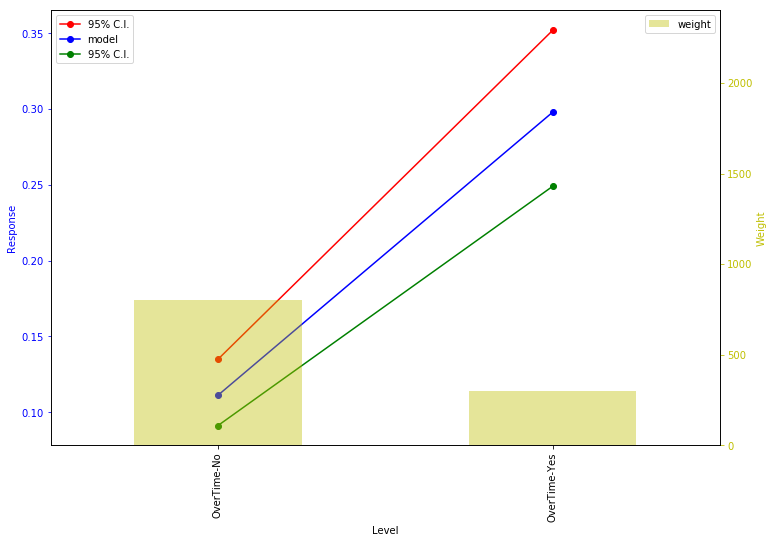

                           Logit Regression Results                           
Dep. Variable:              Attrition   No. Observations:                 1102
Model:                          Logit   Df Residuals:                     1100
Method:                           MLE   Df Model:                            1
Date:                Sun, 18 Feb 2018   Pseudo R-squ.:                 0.05250
Time:                        20:39:13   Log-Likelihood:                -463.27
converged:                       True   LL-Null:                       -488.94
                                        LLR p-value:                 7.770e-13
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
OverTime-No     -2.0780      0.112    -18.482      0.000      -2.298      -1.858
OverTime-Yes    -0.8568      0.126     -6.810      0.000      -1.103      -0.610
Feature: StockOptionLevel
AUC: 0.66507230255

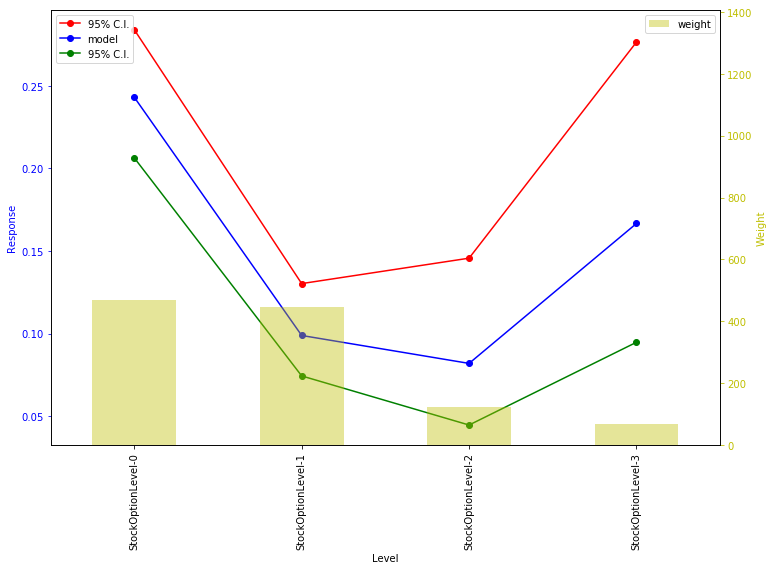

                           Logit Regression Results                           
Dep. Variable:              Attrition   No. Observations:                 1102
Model:                          Logit   Df Residuals:                     1098
Method:                           MLE   Df Model:                            3
Date:                Sun, 18 Feb 2018   Pseudo R-squ.:                 0.04283
Time:                        20:39:14   Log-Likelihood:                -467.99
converged:                       True   LL-Null:                       -488.94
                                        LLR p-value:                 4.247e-09
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
StockOptionLevel-0    -1.1359      0.108    -10.552      0.000      -1.347      -0.925
StockOptionLevel-1    -2.2098      0.159    -13.914      0.000      -2.521      -1.899
StockOptionLevel-2  

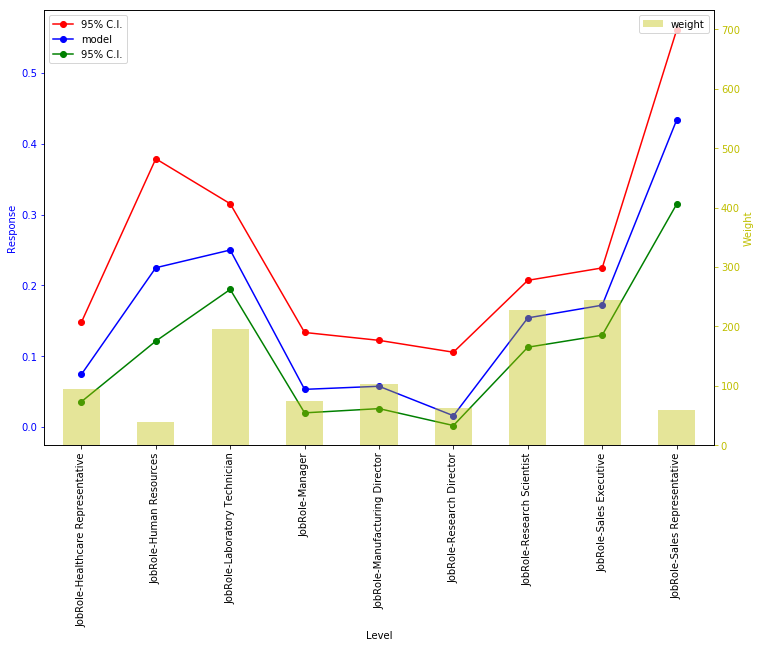

                           Logit Regression Results                           
Dep. Variable:              Attrition   No. Observations:                 1102
Model:                          Logit   Df Residuals:                     1093
Method:                           MLE   Df Model:                            8
Date:                Sun, 18 Feb 2018   Pseudo R-squ.:                 0.07793
Time:                        20:39:15   Log-Likelihood:                -450.83
converged:                       True   LL-Null:                       -488.94
                                        LLR p-value:                 2.823e-13
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
JobRole-Healthcare Representative    -2.5200      0.393     -6.414      0.000      -3.290      -1.750
JobRole-Human Resources              -1.2368      0.379     -3

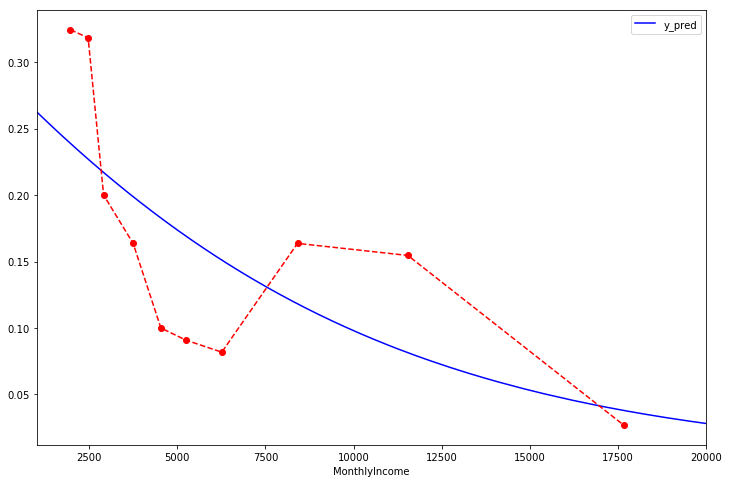

                           Logit Regression Results                           
Dep. Variable:              Attrition   No. Observations:                 1102
Model:                          Logit   Df Residuals:                     1100
Method:                           MLE   Df Model:                            1
Date:                Sun, 18 Feb 2018   Pseudo R-squ.:                 0.03745
Time:                        20:39:15   Log-Likelihood:                -470.62
converged:                       True   LL-Null:                       -488.94
                                        LLR p-value:                 1.432e-09
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.8992      0.148     -6.055      0.000      -1.190      -0.608
MonthlyIncome    -0.0001   2.52e-05     -5.243      0.000      -0.000   -8.27e-05
Feature: MaritalStatus
AUC: 0.6319799777

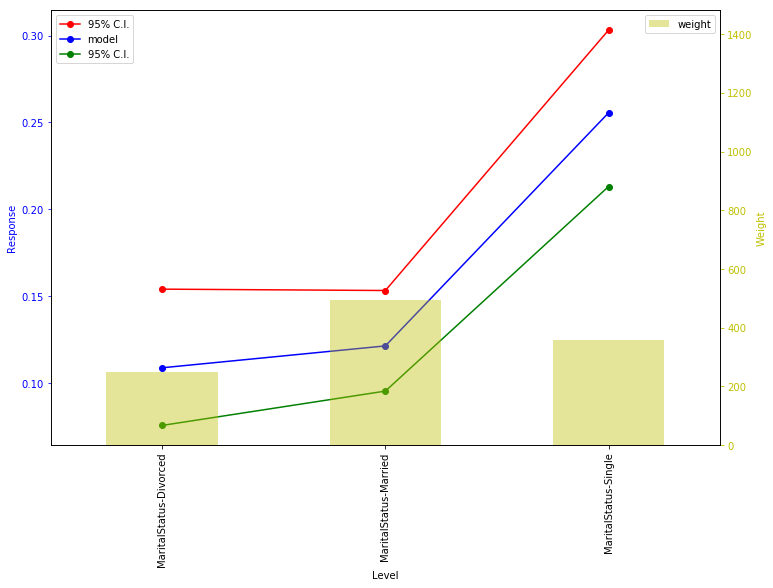

                           Logit Regression Results                           
Dep. Variable:              Attrition   No. Observations:                 1102
Model:                          Logit   Df Residuals:                     1099
Method:                           MLE   Df Model:                            2
Date:                Sun, 18 Feb 2018   Pseudo R-squ.:                 0.03331
Time:                        20:39:16   Log-Likelihood:                -472.65
converged:                       True   LL-Null:                       -488.94
                                        LLR p-value:                 8.434e-08
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
MaritalStatus-Divorced    -2.1023      0.204    -10.312      0.000      -2.502      -1.703
MaritalStatus-Married     -1.9787      0.138    -14.366      0.000      -2.249      -1.709
Mari

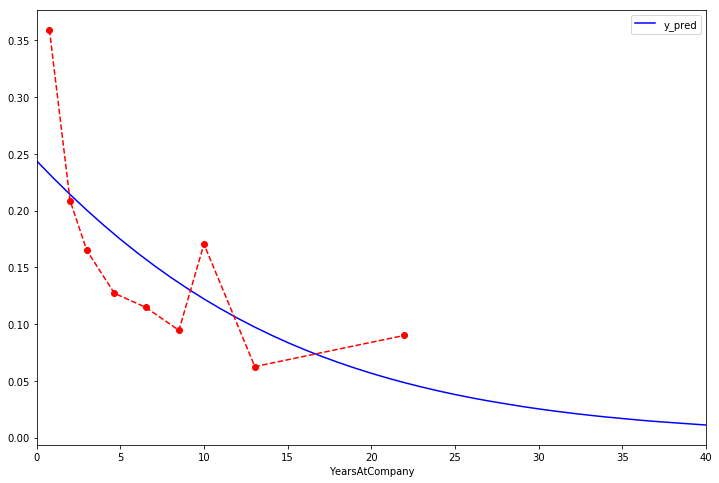

                           Logit Regression Results                           
Dep. Variable:              Attrition   No. Observations:                 1102
Model:                          Logit   Df Residuals:                     1100
Method:                           MLE   Df Model:                            1
Date:                Sun, 18 Feb 2018   Pseudo R-squ.:                 0.02620
Time:                        20:39:16   Log-Likelihood:                -476.13
converged:                       True   LL-Null:                       -488.94
                                        LLR p-value:                 4.164e-07
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -1.1321      0.128     -8.825      0.000      -1.384      -0.881
YearsAtCompany    -0.0841      0.019     -4.515      0.000      -0.121      -0.048
Feature: TotalWorkingYears
AUC: 0.62

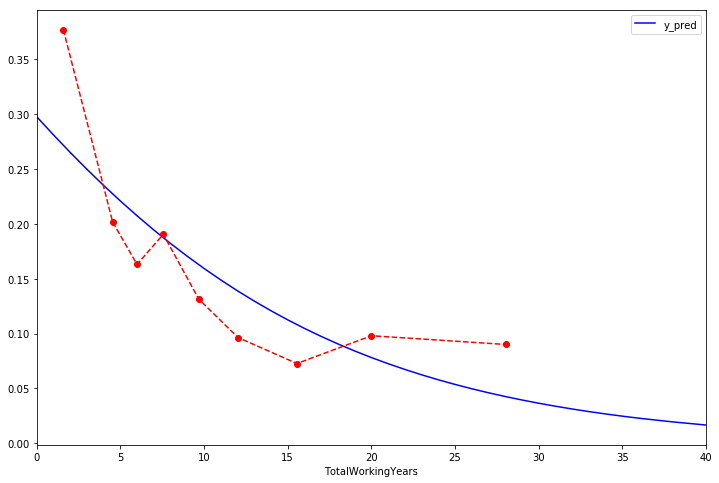

                           Logit Regression Results                           
Dep. Variable:              Attrition   No. Observations:                 1102
Model:                          Logit   Df Residuals:                     1100
Method:                           MLE   Df Model:                            1
Date:                Sun, 18 Feb 2018   Pseudo R-squ.:                 0.04124
Time:                        20:39:17   Log-Likelihood:                -468.77
converged:                       True   LL-Null:                       -488.94
                                        LLR p-value:                 2.152e-10
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.8580      0.146     -5.890      0.000      -1.144      -0.573
TotalWorkingYears    -0.0805      0.014     -5.701      0.000      -0.108      -0.053
Feature: JobInvolvement


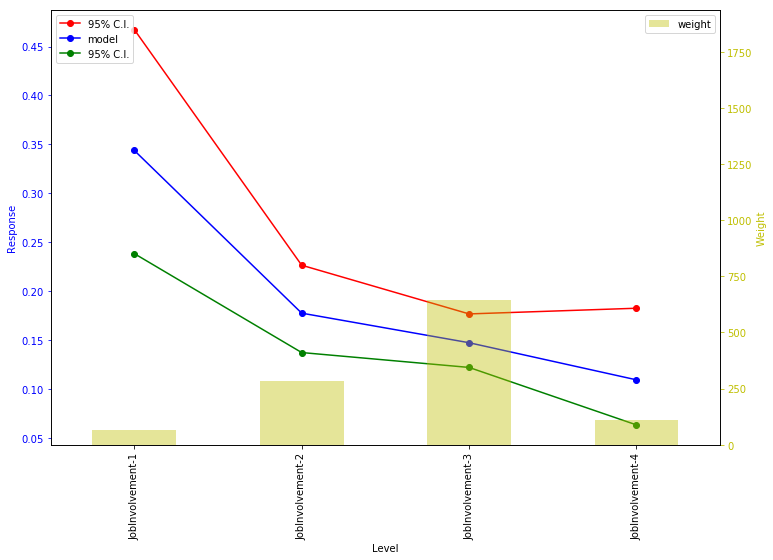

                           Logit Regression Results                           
Dep. Variable:              Attrition   No. Observations:                 1102
Model:                          Logit   Df Residuals:                     1098
Method:                           MLE   Df Model:                            3
Date:                Sun, 18 Feb 2018   Pseudo R-squ.:                 0.01702
Time:                        20:39:17   Log-Likelihood:                -480.62
converged:                       True   LL-Null:                       -488.94
                                        LLR p-value:                 0.0008383
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
JobInvolvement-1    -0.6466      0.263     -2.457      0.014      -1.162      -0.131
JobInvolvement-2    -1.5347      0.156     -9.843      0.000      -1.840      -1.229
JobInvolvement-3    -1.7579 

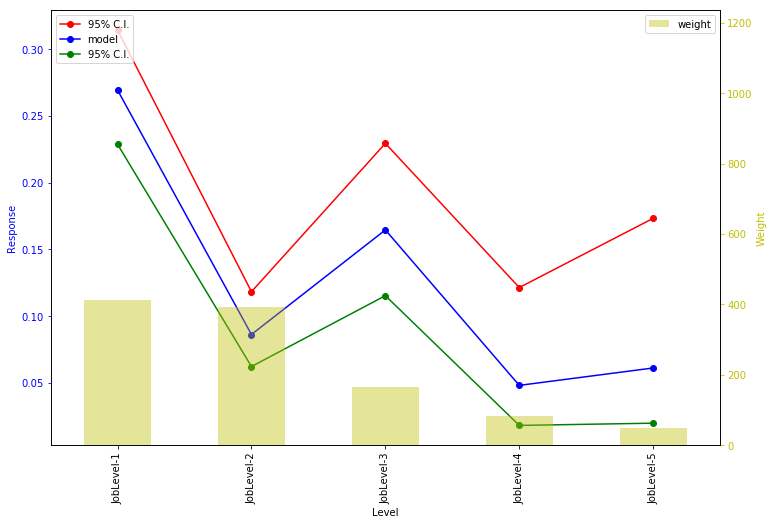

                           Logit Regression Results                           
Dep. Variable:              Attrition   No. Observations:                 1102
Model:                          Logit   Df Residuals:                     1097
Method:                           MLE   Df Model:                            4
Date:                Sun, 18 Feb 2018   Pseudo R-squ.:                 0.06629
Time:                        20:39:18   Log-Likelihood:                -456.52
converged:                       True   LL-Null:                       -488.94
                                        LLR p-value:                 2.800e-13
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
JobLevel-1    -0.9976      0.111     -8.983      0.000      -1.215      -0.780
JobLevel-2    -2.3597      0.179    -13.152      0.000      -2.711      -2.008
JobLevel-3    -1.6241      0.211     -7.713      0.0

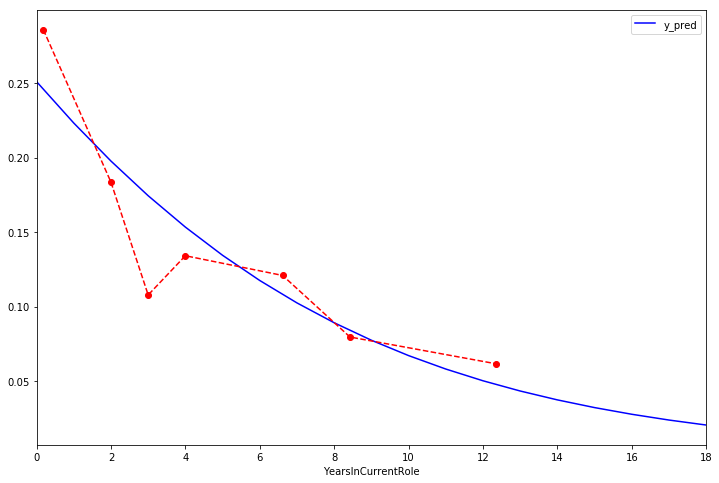

                           Logit Regression Results                           
Dep. Variable:              Attrition   No. Observations:                 1102
Model:                          Logit   Df Residuals:                     1100
Method:                           MLE   Df Model:                            1
Date:                Sun, 18 Feb 2018   Pseudo R-squ.:                 0.03557
Time:                        20:39:18   Log-Likelihood:                -471.54
converged:                       True   LL-Null:                       -488.94
                                        LLR p-value:                 3.686e-09
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -1.0939      0.119     -9.206      0.000      -1.327      -0.861
YearsInCurrentRole    -0.1537      0.028     -5.412      0.000      -0.209      -0.098
Feature: YearsWithCu

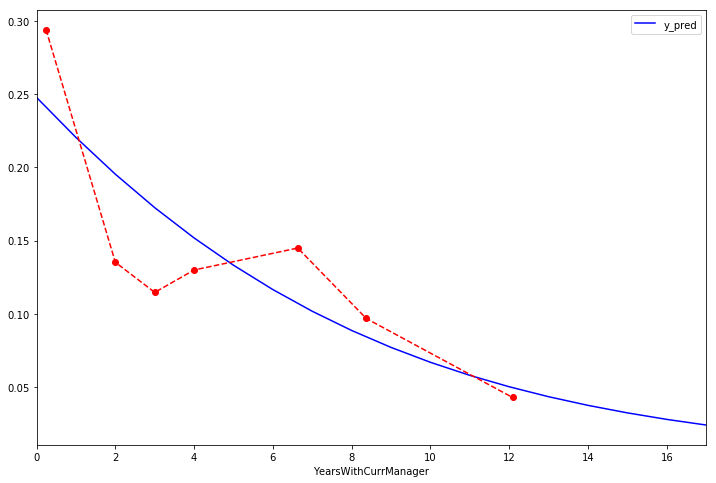

                           Logit Regression Results                           
Dep. Variable:              Attrition   No. Observations:                 1102
Model:                          Logit   Df Residuals:                     1100
Method:                           MLE   Df Model:                            1
Date:                Sun, 18 Feb 2018   Pseudo R-squ.:                 0.03437
Time:                        20:39:19   Log-Likelihood:                -472.13
converged:                       True   LL-Null:                       -488.94
                                        LLR p-value:                 6.740e-09
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -1.1112      0.118     -9.456      0.000      -1.342      -0.881
YearsWithCurrManager    -0.1525      0.028     -5.361      0.000      -0.208      -0.097
Feature: Age

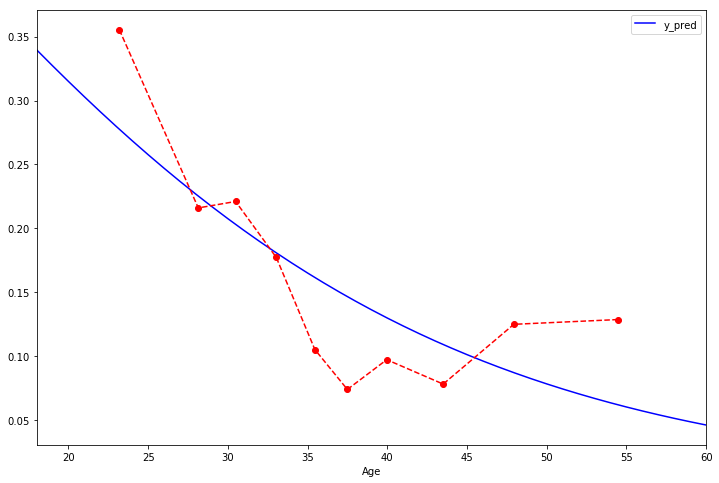

                           Logit Regression Results                           
Dep. Variable:              Attrition   No. Observations:                 1102
Model:                          Logit   Df Residuals:                     1100
Method:                           MLE   Df Model:                            1
Date:                Sun, 18 Feb 2018   Pseudo R-squ.:                 0.03426
Time:                        20:39:19   Log-Likelihood:                -472.19
converged:                       True   LL-Null:                       -488.94
                                        LLR p-value:                 7.121e-09
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3474      0.356      0.976      0.329      -0.351       1.045
Age           -0.0562      0.010     -5.516      0.000      -0.076      -0.036
Feature: DistanceFromHome
AUC: 0.5828142380422692
Tr

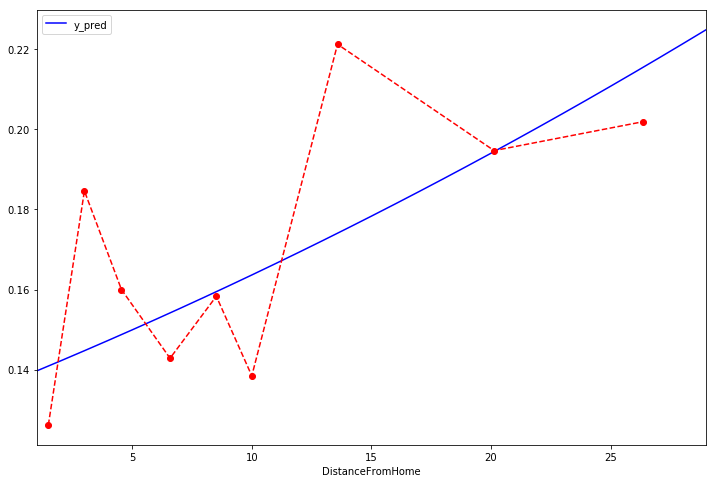

                           Logit Regression Results                           
Dep. Variable:              Attrition   No. Observations:                 1102
Model:                          Logit   Df Residuals:                     1100
Method:                           MLE   Df Model:                            1
Date:                Sun, 18 Feb 2018   Pseudo R-squ.:                0.004592
Time:                        20:39:20   Log-Likelihood:                -486.69
converged:                       True   LL-Null:                       -488.94
                                        LLR p-value:                   0.03409
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -1.8387      0.127    -14.497      0.000      -2.087      -1.590
DistanceFromHome     0.0207      0.010      2.148      0.032       0.002       0.040
Feature: JobSatisfaction
AUC

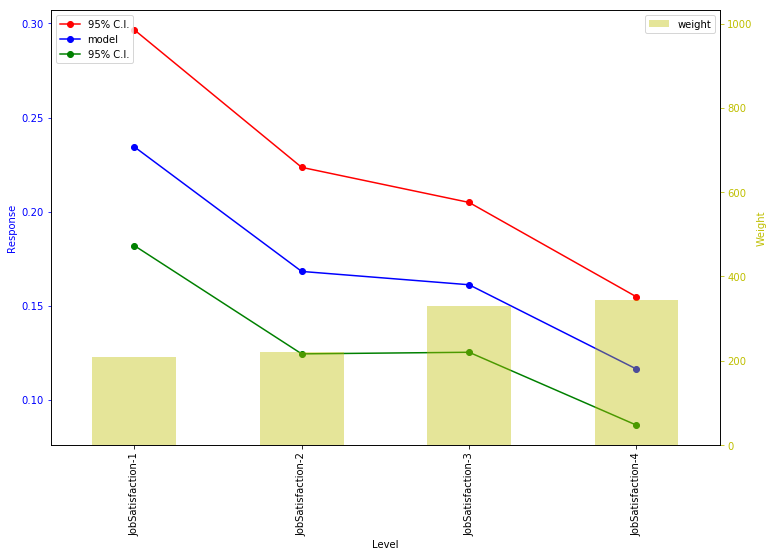

                           Logit Regression Results                           
Dep. Variable:              Attrition   No. Observations:                 1102
Model:                          Logit   Df Residuals:                     1098
Method:                           MLE   Df Model:                            3
Date:                Sun, 18 Feb 2018   Pseudo R-squ.:                 0.01342
Time:                        20:39:20   Log-Likelihood:                -482.38
converged:                       True   LL-Null:                       -488.94
                                        LLR p-value:                  0.004380
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
JobSatisfaction-1    -1.1834      0.163     -7.248      0.000      -1.503      -0.863
JobSatisfaction-2    -1.5986      0.180     -8.868      0.000      -1.952      -1.245
JobSatisfaction-3    -1.

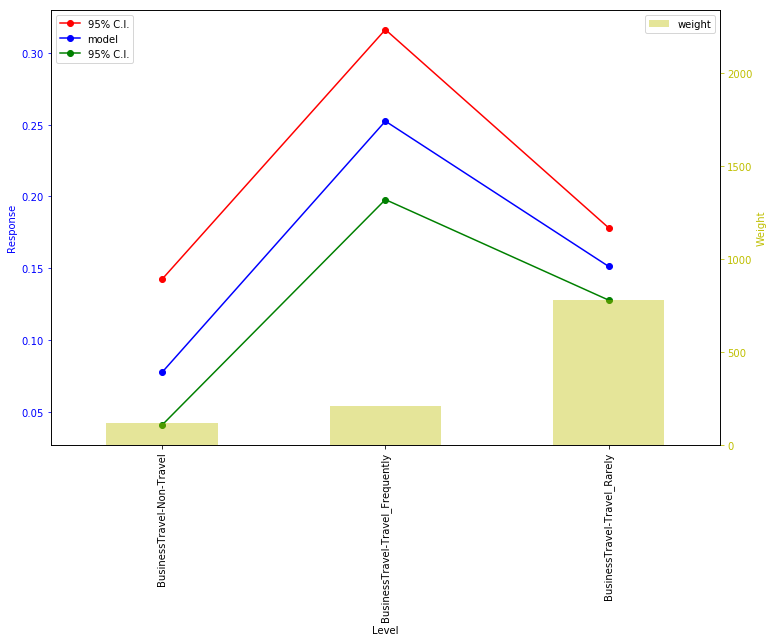

                           Logit Regression Results                           
Dep. Variable:              Attrition   No. Observations:                 1102
Model:                          Logit   Df Residuals:                     1099
Method:                           MLE   Df Model:                            2
Date:                Sun, 18 Feb 2018   Pseudo R-squ.:                 0.01934
Time:                        20:39:21   Log-Likelihood:                -479.48
converged:                       True   LL-Null:                       -488.94
                                        LLR p-value:                 7.810e-05
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
BusinessTravel-Non-Travel           -2.4756      0.347     -7.133      0.000      -3.156      -1.795
BusinessTravel-Travel_Frequently    -1.0857      0.160     -6.769

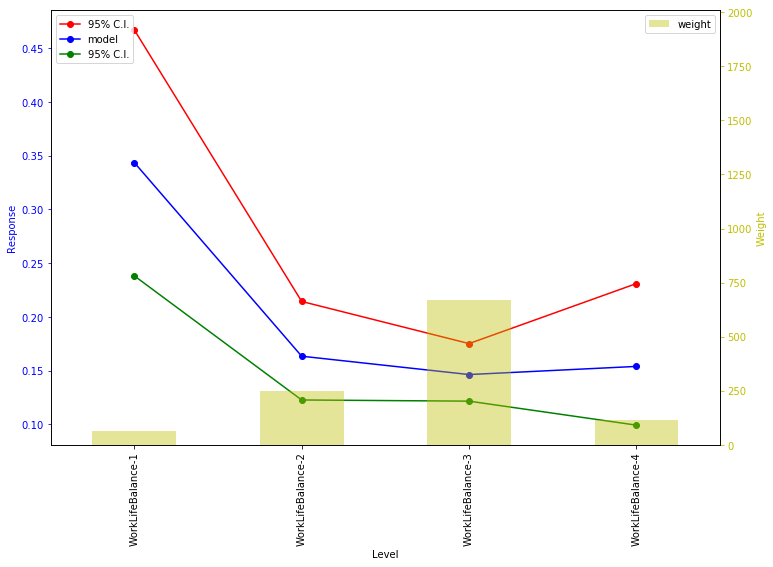

                           Logit Regression Results                           
Dep. Variable:              Attrition   No. Observations:                 1102
Model:                          Logit   Df Residuals:                     1098
Method:                           MLE   Df Model:                            3
Date:                Sun, 18 Feb 2018   Pseudo R-squ.:                 0.01420
Time:                        20:39:22   Log-Likelihood:                -482.00
converged:                       True   LL-Null:                       -488.94
                                        LLR p-value:                  0.003072
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
WorkLifeBalance-1    -0.6466      0.263     -2.457      0.014      -1.162      -0.131
WorkLifeBalance-2    -1.6335      0.171     -9.567      0.000      -1.968      -1.299
WorkLifeBalance-3    -1.

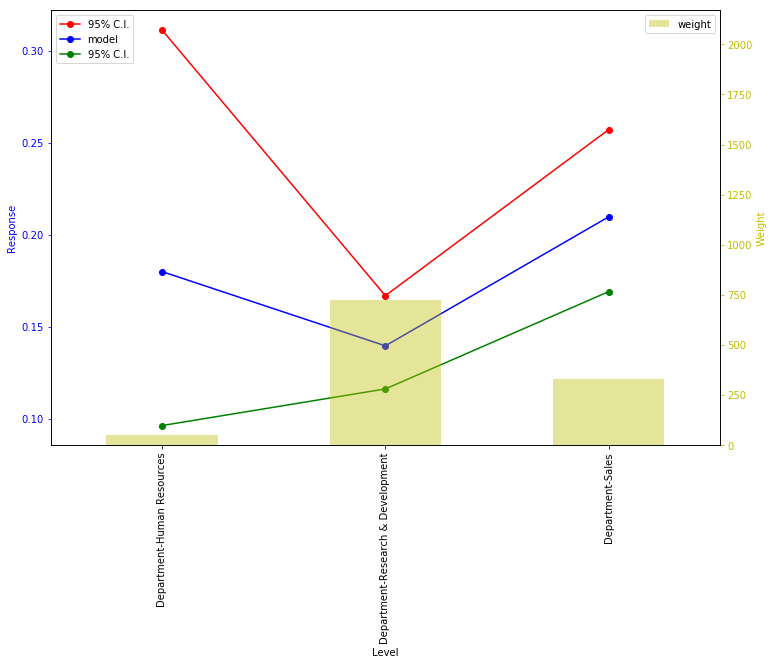

                           Logit Regression Results                           
Dep. Variable:              Attrition   No. Observations:                 1102
Model:                          Logit   Df Residuals:                     1099
Method:                           MLE   Df Model:                            2
Date:                Sun, 18 Feb 2018   Pseudo R-squ.:                0.008191
Time:                        20:39:23   Log-Likelihood:                -484.93
converged:                       True   LL-Null:                       -488.94
                                        LLR p-value:                   0.01822
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Department-Human Resources           -1.5163      0.368     -4.119      0.000      -2.238      -0.795
Department-Research & Development    -1.8178      0.107    -16

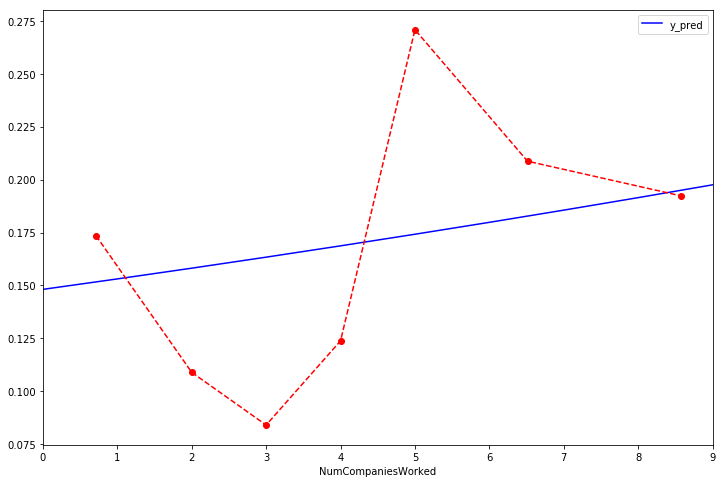

                           Logit Regression Results                           
Dep. Variable:              Attrition   No. Observations:                 1102
Model:                          Logit   Df Residuals:                     1100
Method:                           MLE   Df Model:                            1
Date:                Sun, 18 Feb 2018   Pseudo R-squ.:                0.001540
Time:                        20:39:23   Log-Likelihood:                -488.18
converged:                       True   LL-Null:                       -488.94
                                        LLR p-value:                    0.2198
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -1.7493      0.122    -14.327      0.000      -1.989      -1.510
NumCompaniesWorked     0.0386      0.031      1.238      0.216      -0.022       0.100
Feature: DailyRate
A

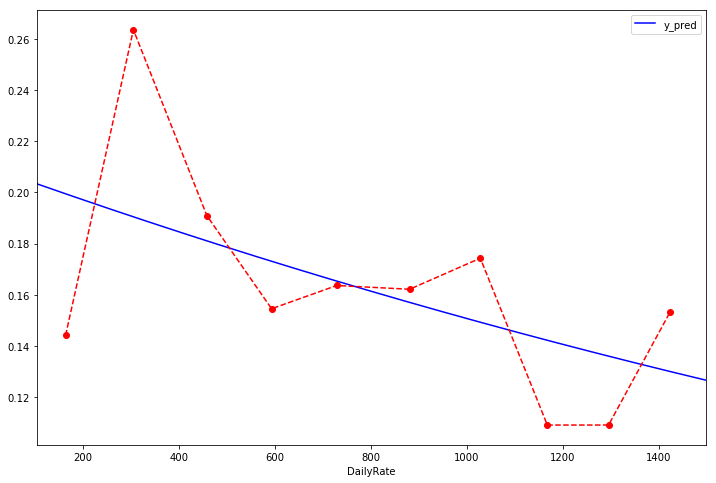

                           Logit Regression Results                           
Dep. Variable:              Attrition   No. Observations:                 1102
Model:                          Logit   Df Residuals:                     1100
Method:                           MLE   Df Model:                            1
Date:                Sun, 18 Feb 2018   Pseudo R-squ.:                0.004179
Time:                        20:39:23   Log-Likelihood:                -486.89
converged:                       True   LL-Null:                       -488.94
                                        LLR p-value:                   0.04323
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.3227      0.173     -7.625      0.000      -1.663      -0.983
DailyRate     -0.0004      0.000     -2.016      0.044      -0.001   -1.12e-05
Feature: TrainingTimesLastYear
AUC: 0.53086763070077

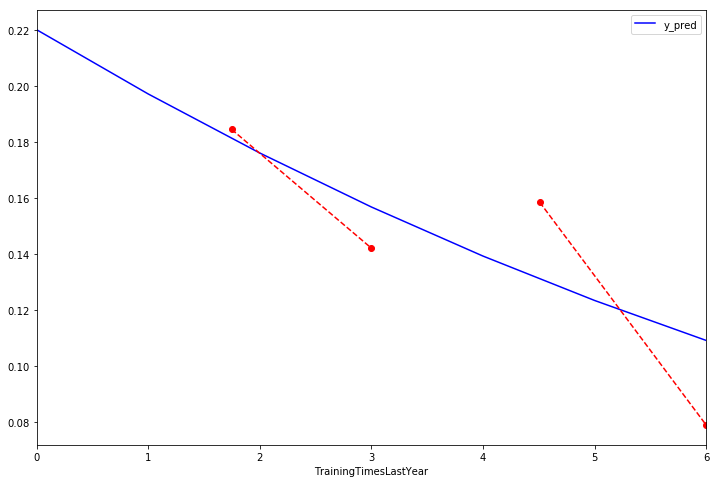

                           Logit Regression Results                           
Dep. Variable:              Attrition   No. Observations:                 1102
Model:                          Logit   Df Residuals:                     1100
Method:                           MLE   Df Model:                            1
Date:                Sun, 18 Feb 2018   Pseudo R-squ.:                0.004433
Time:                        20:39:24   Log-Likelihood:                -486.77
converged:                       True   LL-Null:                       -488.94
                                        LLR p-value:                   0.03733
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -1.2654      0.196     -6.470      0.000      -1.649      -0.882
TrainingTimesLastYear    -0.1390      0.068     -2.054      0.040      -0.272      -0.006
Feature:

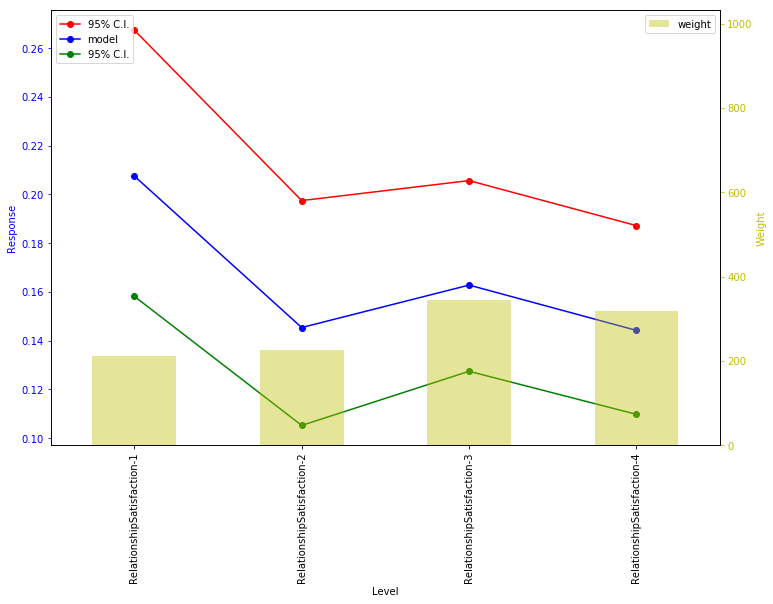

                           Logit Regression Results                           
Dep. Variable:              Attrition   No. Observations:                 1102
Model:                          Logit   Df Residuals:                     1098
Method:                           MLE   Df Model:                            3
Date:                Sun, 18 Feb 2018   Pseudo R-squ.:                0.004366
Time:                        20:39:25   Log-Likelihood:                -486.80
converged:                       True   LL-Null:                       -488.94
                                        LLR p-value:                    0.2338
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
RelationshipSatisfaction-1    -1.3398      0.169     -7.911      0.000      -1.672      -1.008
RelationshipSatisfaction-2    -1.7714      0.188     -9.407      0.000      -2.140 

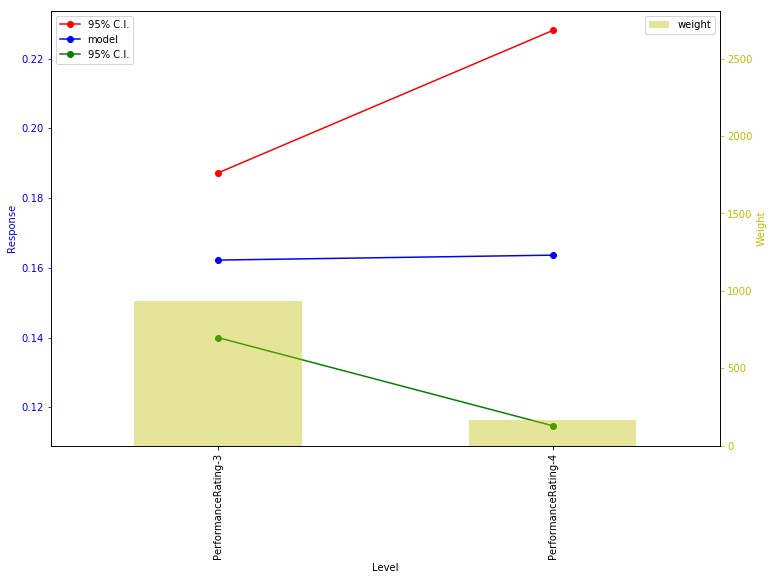

                           Logit Regression Results                           
Dep. Variable:              Attrition   No. Observations:                 1102
Model:                          Logit   Df Residuals:                     1100
Method:                           MLE   Df Model:                            1
Date:                Sun, 18 Feb 2018   Pseudo R-squ.:               2.113e-06
Time:                        20:39:25   Log-Likelihood:                -488.94
converged:                       True   LL-Null:                       -488.94
                                        LLR p-value:                    0.9637
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
PerformanceRating-3    -1.6418      0.089    -18.527      0.000      -1.815      -1.468
PerformanceRating-4    -1.6314      0.210     -7.753      0.000      -2.044      -1.219
Feature: Employe

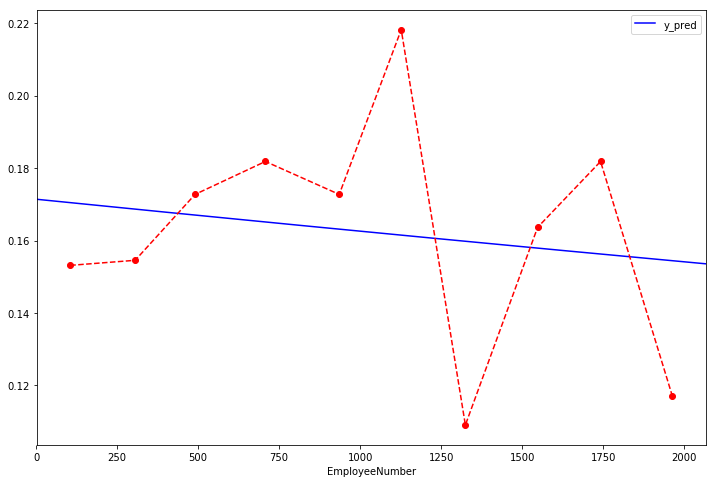

                           Logit Regression Results                           
Dep. Variable:              Attrition   No. Observations:                 1102
Model:                          Logit   Df Residuals:                     1100
Method:                           MLE   Df Model:                            1
Date:                Sun, 18 Feb 2018   Pseudo R-squ.:               0.0002201
Time:                        20:39:26   Log-Likelihood:                -488.83
converged:                       True   LL-Null:                       -488.94
                                        LLR p-value:                    0.6427
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -1.5758      0.160     -9.826      0.000      -1.890      -1.261
EmployeeNumber  -6.34e-05      0.000     -0.464      0.643      -0.000       0.000
Feature: EducationField
AUC: 0.50005

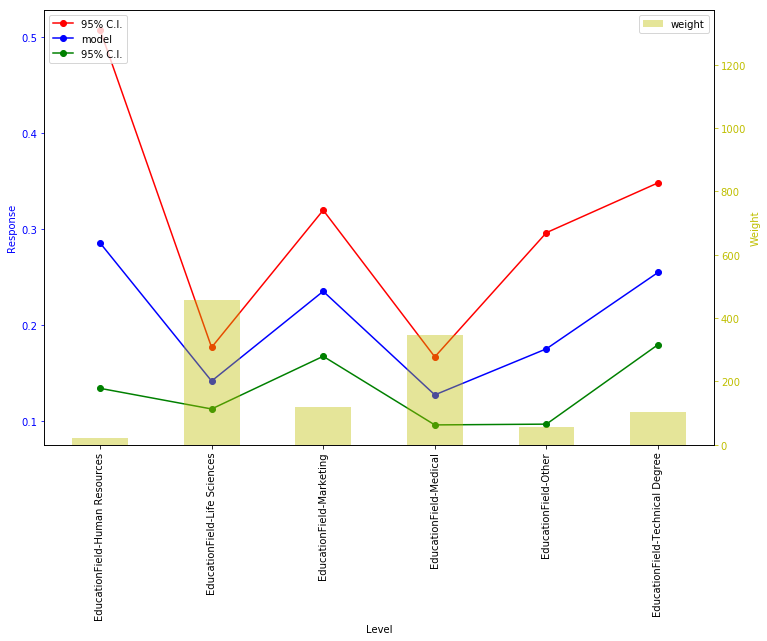

                           Logit Regression Results                           
Dep. Variable:              Attrition   No. Observations:                 1102
Model:                          Logit   Df Residuals:                     1096
Method:                           MLE   Df Model:                            5
Date:                Sun, 18 Feb 2018   Pseudo R-squ.:                 0.01704
Time:                        20:39:26   Log-Likelihood:                -480.60
converged:                       True   LL-Null:                       -488.94
                                        LLR p-value:                  0.005181
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
EducationField-Human Resources     -0.9163      0.483     -1.897      0.058      -1.863       0.030
EducationField-Life Sciences       -1.7994      0.134    -13.439    

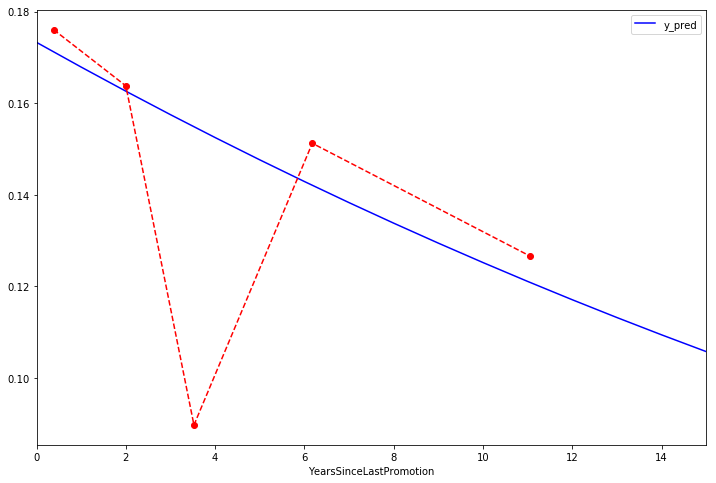

                           Logit Regression Results                           
Dep. Variable:              Attrition   No. Observations:                 1102
Model:                          Logit   Df Residuals:                     1100
Method:                           MLE   Df Model:                            1
Date:                Sun, 18 Feb 2018   Pseudo R-squ.:                0.002034
Time:                        20:39:27   Log-Likelihood:                -487.94
converged:                       True   LL-Null:                       -488.94
                                        LLR p-value:                    0.1584
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -1.5625      0.098    -16.008      0.000      -1.754      -1.371
YearsSinceLastPromotion    -0.0381      0.028     -1.368      0.171      -0.093       0.017


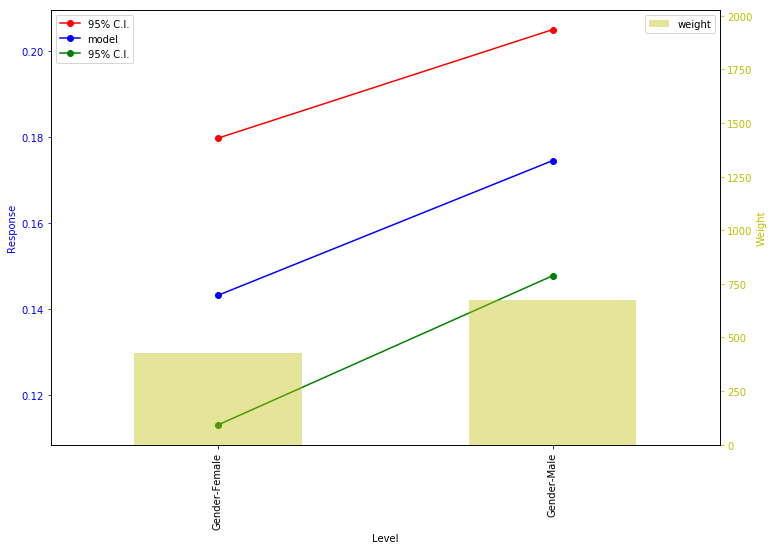

                           Logit Regression Results                           
Dep. Variable:              Attrition   No. Observations:                 1102
Model:                          Logit   Df Residuals:                     1100
Method:                           MLE   Df Model:                            1
Date:                Sun, 18 Feb 2018   Pseudo R-squ.:                0.001958
Time:                        20:39:28   Log-Likelihood:                -487.98
converged:                       True   LL-Null:                       -488.94
                                        LLR p-value:                    0.1664
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Gender-Female    -1.7890      0.138    -12.934      0.000      -2.060      -1.518
Gender-Male      -1.5537      0.101    -15.334      0.000      -1.752      -1.355
Feature: EnvironmentSatisfaction
AUC: 0.

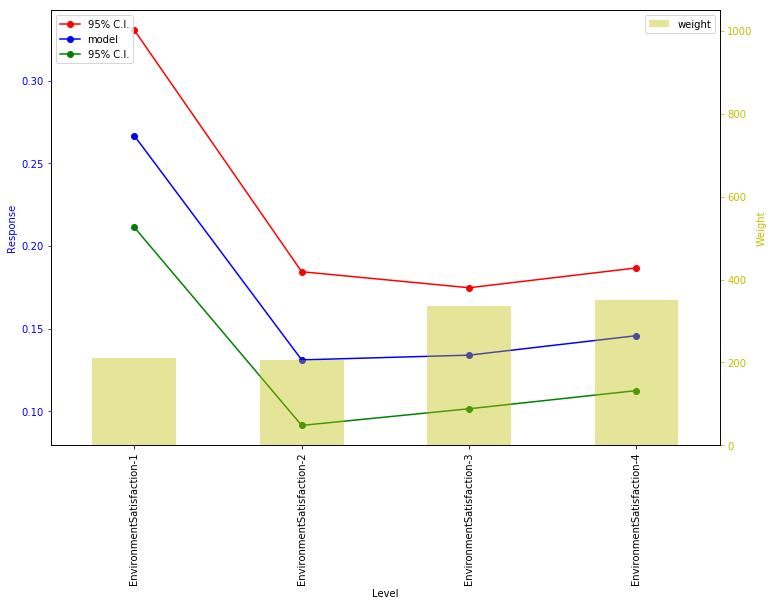

                           Logit Regression Results                           
Dep. Variable:              Attrition   No. Observations:                 1102
Model:                          Logit   Df Residuals:                     1098
Method:                           MLE   Df Model:                            3
Date:                Sun, 18 Feb 2018   Pseudo R-squ.:                 0.01945
Time:                        20:39:28   Log-Likelihood:                -479.43
converged:                       True   LL-Null:                       -488.94
                                        LLR p-value:                 0.0002714
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
EnvironmentSatisfaction-1    -1.0116      0.156     -6.483      0.000      -1.317      -0.706
EnvironmentSatisfaction-2    -1.8915      0.206     -9.162      0.000      -2.296     

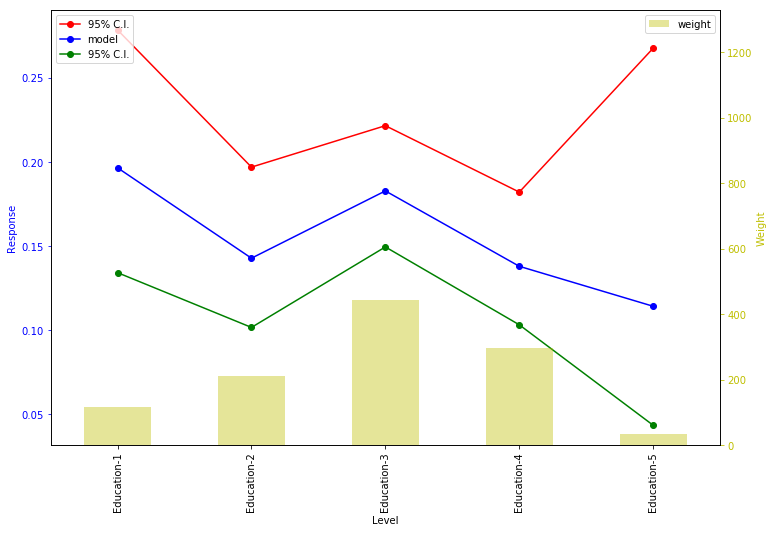

                           Logit Regression Results                           
Dep. Variable:              Attrition   No. Observations:                 1102
Model:                          Logit   Df Residuals:                     1097
Method:                           MLE   Df Model:                            4
Date:                Sun, 18 Feb 2018   Pseudo R-squ.:                0.004996
Time:                        20:39:29   Log-Likelihood:                -486.49
converged:                       True   LL-Null:                       -488.94
                                        LLR p-value:                    0.2993
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Education-1    -1.4078      0.233     -6.052      0.000      -1.864      -0.952
Education-2    -1.7918      0.197     -9.086      0.000      -2.178      -1.405
Education-3    -1.4972      0.123    -12.181    

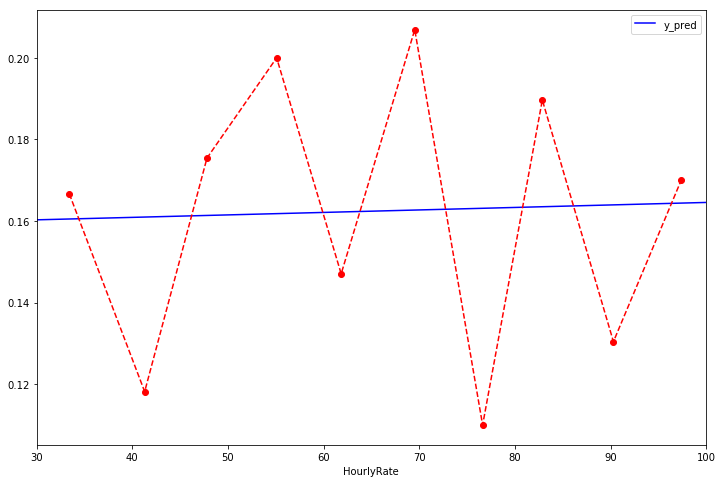

                           Logit Regression Results                           
Dep. Variable:              Attrition   No. Observations:                 1102
Model:                          Logit   Df Residuals:                     1100
Method:                           MLE   Df Model:                            1
Date:                Sun, 18 Feb 2018   Pseudo R-squ.:               1.276e-05
Time:                        20:39:29   Log-Likelihood:                -488.93
converged:                       True   LL-Null:                       -488.94
                                        LLR p-value:                    0.9111
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.6695      0.274     -6.082      0.000      -2.207      -1.132
HourlyRate     0.0004      0.004      0.112      0.911      -0.007       0.008
Feature: MonthlyRate
AUC: 0.46159621802002226
Traini

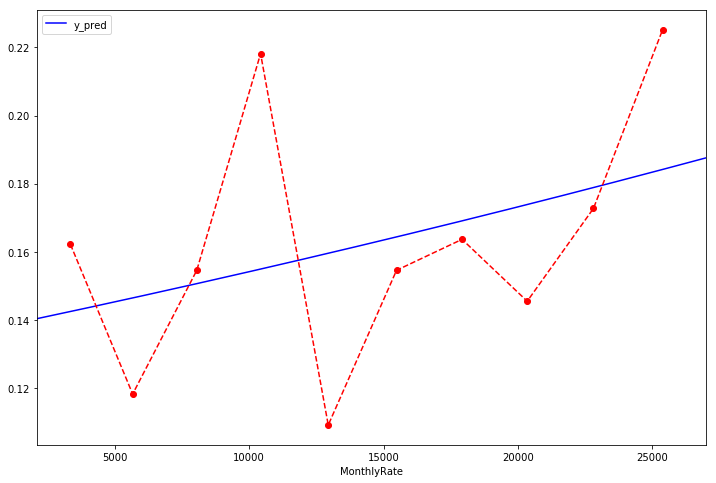

                           Logit Regression Results                           
Dep. Variable:              Attrition   No. Observations:                 1102
Model:                          Logit   Df Residuals:                     1100
Method:                           MLE   Df Model:                            1
Date:                Sun, 18 Feb 2018   Pseudo R-squ.:                0.001494
Time:                        20:39:30   Log-Likelihood:                -488.21
converged:                       True   LL-Null:                       -488.94
                                        LLR p-value:                    0.2268
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.8419      0.188     -9.779      0.000      -2.211      -1.473
MonthlyRate  1.393e-05   1.15e-05      1.207      0.227   -8.68e-06    3.65e-05


In [9]:
warnings.filterwarnings('ignore')

ModelTools.UnivariateAnalysis(model_data.feature_level_index, X_train, Y_train, X_val, Y_val, p_top_k_features=30, p_model='binary', p_metric = 'AUC', p_n_buckets = 10)

<a name="random-forest-univariate-analysis"></a>
## Random Forest Univariate Analysis

The idea here is to start with all the predictors and iteratively remove one variable at a time, and calculate the loss in overall fit. A larger loss in fit implies a higher marginal importance of the variable. This gives a slightly different perspective than the linear univariate analysis above. Given a group of correlated and highly predictive variables, they will all come through as predictive in the section above since one variable is being fitted at a time, whereas here removing one of these variables should not affect the overall fit too much since the other correlated variables should pick up the lost signal. Here the focus is more on unique contribution of each variable. 
<br>
To avoid over-fitting, p_cross_validations (defaulted to 5) will be used for cross-validation using p_validation_fraction (defaulted to 0.25) for the test set size. In order to reduce run-time, instead of actually removing variables and re-fitting, we will fit the model on the training set and then randomize the variable we would like to remove in order to break any relationship between it and the target variable. This allows us to fit the model once (for each cross-validation set) and infer for each of our predictors instead of re-fitting it for each of our predictors. 

In [10]:
from ModelToolBox.UnivariatePermutations import *
from Models.skModels import *
warnings.filterwarnings('ignore')

RF_model = sklearn_Model("Random Forest", 'sklearn.ensemble', 'RandomForestClassifier', 'accuracy')
univariate_permutations(RF_model, model_data.feature_level_index, X_train, Y_train, p_hyperparams = 250)

*****************Features sorted by their score:*****************
YearsWithCurrManager: 0.00676
Education: 0.00594
DistanceFromHome: 0.00515
Gender: 0.00337
YearsAtCompany: 0.00260
JobRole: 0.00259
WorkLifeBalance: 0.00258
EmployeeNumber: 0.00251
JobInvolvement: 0.00175
PerformanceRating: 0.00168
BusinessTravel: 0.00166
EnvironmentSatisfaction: 0.00091
TotalWorkingYears: 0.00006
TrainingTimesLastYear: 0.00000
MonthlyRate: -0.00083
RelationshipSatisfaction: -0.00084
DailyRate: -0.00088
NumCompaniesWorked: -0.00088
JobLevel: -0.00168
MonthlyIncome: -0.00168
YearsInCurrentRole: -0.00168
YearsSinceLastPromotion: -0.00170
PercentSalaryHike: -0.00172
EducationField: -0.00175
Department: -0.00177
HourlyRate: -0.00255
JobSatisfaction: -0.00346
StockOptionLevel: -0.00353
MaritalStatus: -0.00425
Age: -0.00429
OverTime: -0.00771


<a name="gradient-boosting-univariate-analysis"></a>
## Gradient Boosting Univariate Analysis

This section is analagous to the Random Forest Univariate Analysis section above, except using Gradient Boosting models instead of Random Forest models. 

In [11]:
GB_model = sklearn_Model("Gradient Boosting", 'sklearn.ensemble', 'GradientBoostingClassifier', 'accuracy')
univariate_permutations(GB_model, model_data.feature_level_index, X_train, Y_train, p_hyperparams = 1000)

*****************Features sorted by their score:*****************
PercentSalaryHike: 0.00715
DistanceFromHome: 0.00715
Education: 0.00452
DailyRate: 0.00434
TrainingTimesLastYear: 0.00358
JobSatisfaction: 0.00274
Gender: 0.00274
EmployeeNumber: 0.00181
WorkLifeBalance: 0.00179
BusinessTravel: 0.00095
Department: 0.00091
HourlyRate: -0.00087
PerformanceRating: -0.00088
JobRole: -0.00091
EducationField: -0.00092
YearsWithCurrManager: -0.00092
RelationshipSatisfaction: -0.00188
MaritalStatus: -0.00199
StockOptionLevel: -0.00272
YearsInCurrentRole: -0.00280
YearsSinceLastPromotion: -0.00282
JobInvolvement: -0.00627
YearsAtCompany: -0.00637
MonthlyRate: -0.00805
NumCompaniesWorked: -0.00810
EnvironmentSatisfaction: -0.00991
JobLevel: -0.01203
Age: -0.01287
MonthlyIncome: -0.02302
OverTime: -0.02603
TotalWorkingYears: -0.02683


<a name="part-two---model-comparison"></a>
# Part Two - Model Comparison

Early in the modeling process a decision needs to made about which type of model to use. This choice should be driven by the nature of the modeling problem, the nature of the data, and the relationship between the predictors and the target variable. Even after these considerations have been made there are often multiple viable options. This section compares the fit of different models using all of the predictor variables (this can be changed the p_predictors argument). Within the code you can choose the set of hyperparameters you want to test for each model. Soon there will be an additional section here to do a hyperparameter search using some combination of Bayesian Optimization, grid search, and random search.

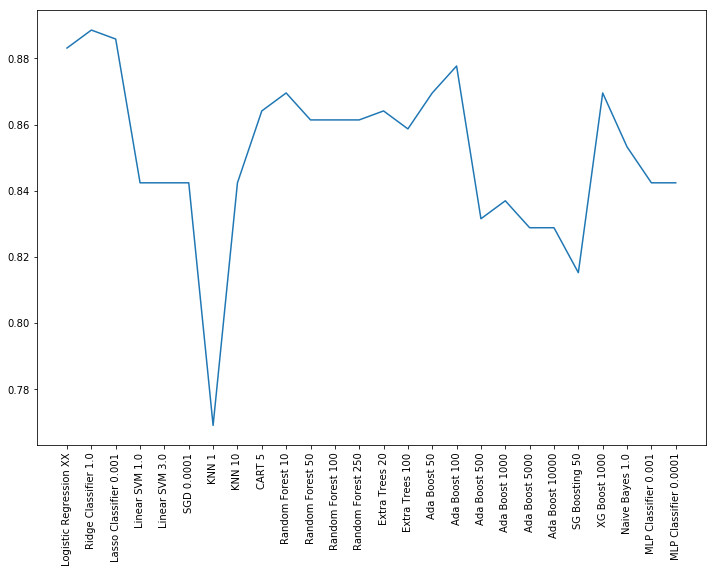

                     Model  Validation Fit
1     Ridge Classifier 1.0        0.888587
2   Lasso Classifier 0.001        0.885870
0   Logistic Regression XX        0.883152
16           Ada Boost 100        0.877717
22           XG Boost 1000        0.869565
15            Ada Boost 50        0.869565
9         Random Forest 10        0.869565
8                   CART 5        0.864130
13          Extra Trees 20        0.864130
10        Random Forest 50        0.861413
11       Random Forest 100        0.861413
12       Random Forest 250        0.861413
14         Extra Trees 100        0.858696
23         Naive Bayes 1.0        0.853261
7                   KNN 10        0.842391
24    MLP Classifier 0.001        0.842391
3           Linear SVM 1.0        0.842391
25   MLP Classifier 0.0001        0.842391
4           Linear SVM 3.0        0.842391
5               SGD 0.0001        0.842391
18          Ada Boost 1000        0.836957
17           Ada Boost 500        0.831522
19         

In [12]:
#warnings.filterwarnings('ignore')

import ModelToolBox.ModelComparison as MC

MC.model_comparison_classification_stdset(p_X_train = X_train,
                                          p_X_val = X_val,
                                          p_Y_train = Y_train,
                                          p_Y_val = Y_val,
                                          p_predictors = model_data.predictors,
                                          p_metric = 'accuracy')  

<a name="part-three---variable-selection"></a>
# Part Three - Variable Selection

Once a model has been chosen, we need to decide which predictor variables to include. Variable selection will be done using backward and forward stepwise selection. The backward part of this algorithm begins by starting with all, say $n$, predictor variables and iteratively removing one variable at a time and measuring the change in performance. The worst performing variable is then removed from the model. We repeat the process with the $n-1$ remaining variables, again removing the worst performing variable. This continues until all of the remaining variables make a "significant" contribution to the model fit. The specific stopping criteria will depend on the problem and metric that is chosen. The forward stepwise selection will then be run (if p_forward = True), by iteratively adding each of the variables that were removed in the backward selection. The most significant, if there any, will be added back to the model. This process continues until none of the remaining variables significantly improve the model.
<br>
It may not be immediately clear why the forward iteration is useful. The backward (and forward) stepwise selection is a greedy algorithm and may find a local optimum in the feature space. Running the forward iteration will increase the chance of finding the global optimum, however does not guarantee it. Ideally we would compare the model fit on every subset of our preditor variables, however this is computationally expensive with $O(2^n)$ run-time, compared to $O(n^2)$ run-time with the backward/forward selection.

<a name="random-forest"></a>
## Random Forest

Here we run backward and forward stepwise selection with Random Forest models. Similar to the univariate random forest section we will cross-validate using p_cross_validations splits and p_validation_fraction portion of the data in each test set. And again to reduce run-time, instead of removing variables and re-fitting, we will randomize the variable we would like to remove which should have the same effect. 

In [13]:
from ModelToolBox.ForBack import *

for_back_permutations(RF_model, model_data.feature_level_index, model_data.predictors, X_train, Y_train, X_val, Y_val, p_hyperparams=250)

*******Variable Performance From Final Backward Iteration:*******
PercentSalaryHike: 0.00861
PerformanceRating: 0.00860
BusinessTravel: -0.00176
****************The optimal set of variables is:*****************
PercentSalaryHike
PerformanceRating
OverTime
NumCompaniesWorked


<a name="gradient-boosting"></a>
## Gradient Boosting

This section is analagous to the one above, except using gradient boosting.

In [14]:
for_back_permutations(GB_model, model_data.feature_level_index, model_data.predictors, X_train, Y_train, X_val, Y_val, p_hyperparams=1000, p_threshold=0.1)

ValueError: Found array with 0 feature(s) (shape=(826, 0)) while a minimum of 1 is required.